**Goal**: Get familiar with evolutionary algorithms by implementing it and applying it to a given non-differentiable optimization task.

Learn about evolutionary algorithms (EAs). The goal is to implement components of an evolutionary algorithm: a recombination operator, a mutation operator, and selection mechanisms, and analyze their behavior. This assignment is open to any choice of the aforementioned components​ as long as they are well motivated.

We are interested in optimizing a given **black-box** function that could be queried (i.e., it returns a value of the objective for given input values), but the gradient wrt the input cannot be calculated. The input to the system is a vector:
$$\mathbf{x} =[\alpha_0, n, \beta, \alpha]^{\top} \in [−2,10] \times [0,10] \times [−5,20] \times [500,2500]. $$

The optimized function is based on the gene repressilator model. For details, please see Section 4.2 in <a href='https://arxiv.org/abs/2002.02869' target='_blank'>HERE</a>.

## 1. Understanding the problem

The considered problem is about finding parameter values of a model widely used in biology, namely, the gene repressilator model. This model represents a simple network in which a gene (mRNA) is produced by a protein, and then this gene is used to produce another protein. Altogether, there are 3 genes and 3 proteins that are connected as follows: $m_1 \rightarrow p_1$, $p_1 \rightarrow m_2$, $m_2 \rightarrow p_2$, $p_2 \rightarrow m_3$, $m_3 \rightarrow p_3$, $p_3 \rightarrow m_1$.

Please run the code below and spend a while on analyzing the signals in the model. Think of the osscilatory character of the signals.

If any code line is unclear to you, please read on that in numpy or matplotlib docs.

In [48]:
import copy
import pickle

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

EPS = 1.0e-7

In [49]:
# PLEASE DO NOT REMOVE!
# This is the main class for the gene repressilator model.
# There is no need to understand how it works! You can treat it as a black-box.
# It is important to realize that we can always ask this object to give us
# an evaluation of given parameter values.
class Repressilator(object):
    def __init__(self, y_real, params):
        super().__init__()
        self.y_real = y_real.copy()
        self.params = params.copy()

    # The definition of the gene repressilator model as a system of ODEs.
    def repressilator_model(self, t, y):
        m1, m2, m3, p1, p2, p3 = y[0], y[1], y[2], y[3], y[4], y[5]

        alpha0 = self.params["alpha0"]
        n = self.params["n"]
        beta = self.params["beta"]
        alpha = self.params["alpha"]

        dm1_dt = -m1 + alpha / (1.0 + p3**n) + alpha0
        dp1_dt = -beta * (p1 - m1)
        dm2_dt = -m2 + alpha / (1.0 + p1**n) + alpha0
        dp2_dt = -beta * (p2 - m2)
        dm3_dt = -m3 + alpha / (1.0 + p2**n) + alpha0
        dp3_dt = -beta * (p3 - m3)

        return dm1_dt, dm2_dt, dm3_dt, dp1_dt, dp2_dt, dp3_dt

    # A numerial solver for the model (here we use Runge-Kutta 4.5)
    def solve_repressilator(self):
        # we need to use lambda function if we want to pass some parameters
        solution = solve_ivp(
            lambda t, y: self.repressilator_model(t, y),
            t_span=(self.params["t0"], self.params["t1"]),
            y0=self.params["y0"],
            method="RK45",
            t_eval=self.params["t_points"],
        )
        y_points = np.asarray(solution.y)
        return self.params["t_points"], y_points

    # An auxiliary function: setting parameters.
    def set_params(self, x):
        self.params["alpha0"] = x[0]
        self.params["n"] = x[1]
        self.params["beta"] = x[2]
        self.params["alpha"] = x[3]

    # Calculating the objective function.
    # Here, we use the Euclidean distance between the real data and the synthetic data.
    @staticmethod
    def loss(y_real, y_model):
        # we assume only m's are observed!
        y_r = y_real[0:3]
        y_m = y_model[0:3]
        if y_r.shape[1] == y_m.shape[1]:
            return np.mean(np.sqrt(np.sum((y_r - y_m) ** 2, 0)))
        else:
            return np.infty

    def objective(self, x):
        if len(x.shape) > 1:
            objective_values = []
            for i in range(x.shape[0]):
                xi = x[i]
                self.set_params(xi)

                _, y_model = self.solve_repressilator()
                objective_values.append(self.loss(self.y_real, y_model))

            objective_values = np.asarray(objective_values)
        else:
            self.set_params(x)

            _, y_model = self.solve_repressilator()
            objective_values = self.loss(self.y_real, y_model)

        return objective_values

In [50]:
# PLEASE DO NOT REMOVE!
# Initialize the problem.
# Here we set the real parameters and generate "real" data. To make the problem
# more realistic, we add a small Gaussian noise.
params = {}
params["alpha0"] = 1.1
params["n"] = 2.9
params["beta"] = 5.5
params["alpha"] = 500
params["t0"] = 0.0
params["t1"] = 60.5
params["t_points"] = np.arange(0, 60, 0.5)
params["x0"] = np.asarray([[5.64167522, 2.07180539, 3.56690274, 7.0015145]])
params["y0"] = np.asarray([0.0, 0.0, 0.0, 2.0, 1.0, 3.0])

# Generate "real" data
r = Repressilator([0], params)
_, y_real = r.solve_repressilator()
del r  # we remove the object, just in case
y_real = y_real + np.random.randn(*y_real.shape) * 5.0  # add noise!

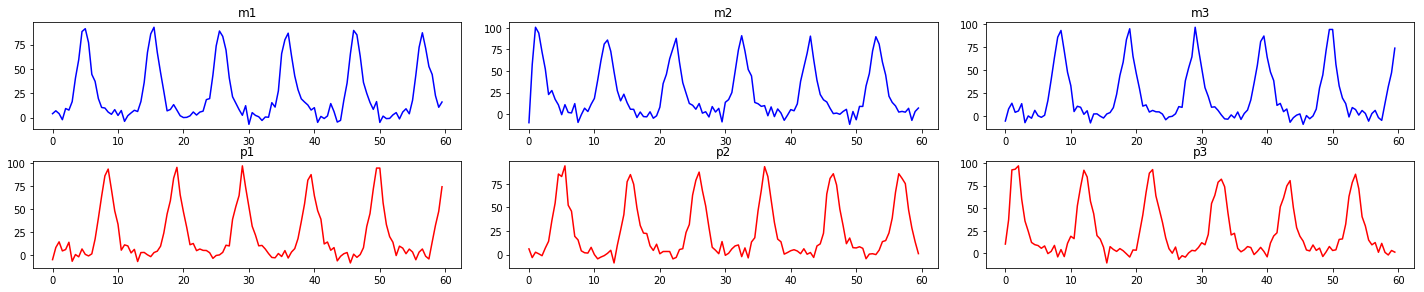

In [51]:
# PLEASE DO NOT REMOVE
# Here, we plot all signals in the model.
# Note that later on, we assume that only gene expression (i.e., m1, m2, m3)
# are observed (blue plots) and proteins (i.e. p1, p2, p3) are unobserved (in red).
t = params["t_points"]

fig_data, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_data.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
        else:
            title = "p"
            color = "r"

        axs[i, j].plot(t, y_real[2 * i + j], color)
        axs[i, j].set_title(title + str(j + 1))

## 2. Evolutionary Algorithms

In this assignment, you are asked to implement an evolutionary algorithm (EA). Please take a look at the class below and fill in the missing parts. Please keep in mind that you are free to choose any operations as lons as they are appropriate for evolutionary algorithms.

NOTE: Please pay attention to the inputs and outputs of each function.

**Question 1 (0-0.5pt):** Do you use a mutation operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:**
Our representation is continous, so I choosed the mutation operator be compatible with the representation. I added two different mutation operations: Random Perturbation and differential mutation. For random perturbation we need a sample values from a probability distribution. Our given distribution follows a sinus-like function. So, I choosed a normal distribution to find the noise. For differential mutation, we need to choose a random vector from the population. Here, there are 2 hyperparameters. First one is mutation rate which makes us to decide if we do perform mutation on particular individual. Other one is scaling factor, that is used in differential mutation. It is used to decide on how much difference vector of two randomly selected individual will contribute to the third individual. For overall mutation, I randomly select one of the two mutation operations. My reason, I wanted to see the effect of both mutation operations on the population. Since we are doing many iterations, we can benefit from both of them and also it introduces diversity to the population.

**Question 2 (0-0.5pt):** Do you use a cross-over operator? If yes, please explain in detail your choice. If not, please explain why not.

**Answer:** At the starting, I used one-point crossover for the recombination operator. As this is a problem that comes from biology and because, there might be a strong relationship between the genes and they not be independent from each other, I thought one-point crossover migth be the right option. One-point crossover selects a point of the genes and swaps the genes after that point. I believe that it is a good balance between exploration and exploitation. However, I also wanted to try more complex and diverse options. I added 'n_point_crossover' as well. My mechanism works as follows: 0.5 -> one point, 0.25 -> two point, 0.20 -> 3 point, 0.05 -> uniform. I wanted to introduce a randomness more rather than just 1-point. Here, I used recombination rate as hyperparameter to decide if we do perform recombination on particular individual. 

**Question 3 (0-0.5pt):** What kind of selection mechanism do you use? Please explain in detail and motivation your choice.

**Answer:**
There are two categories of selection. One is parent selection, other is the survivor selection. 
- For parent selection, I used linear ranking selection. Here, the probability of selection is proportional to the rank of the individual. The rank is calculated by the fitness of the individual. The probability of selection is calculated by the formula: $P(i) = \frac{1}{N} (sp - \frac{(2sp-2)(rank_i - 1)}{(N-1)})$ where $N$ is the number of individuals in the population and $sp$ is the selection pressure. The selection pressure is a parameter that controls the selection pressure. The higher the selection pressure, the more likely the fittest individual is to be selected. Thus, selection pressure was a hyperparameter that I tuned. The reason for me to choose this selection mechanism is that it introduces a bias towards the fittest individuals  whereas it still allows less fit individuals to be selected and introduces stochasticity in the selection process in contrast to random selection in which there is no importance of the fitness of the individuals. 
- For survivor selection, I used two mechanisms: elitism and ($\mu, \lambda$) selection. Here, $\mu$ is the number of parents and $\lambda$ is the number of children. For ($\mu, \lambda$) selection, I used this because since it leaves all odd solutions out there is a chance that it would escape from local optimum solutions. However, as a downside it may forgot / discard good solutions or important information that comes through older generations. The reason for me to include elitism is exactly to cover this downside: to make sure we keep best individuals in the old parents/ population . Even if the whole offspring selections are better than the parents, it is important to keep the best ones from parents because they've been the best ones so far and might contain important information that will be useful in the following offsprings. Here, k which is the number of individuals to keep in parents is a hyperparameter I tuned.

**Question 4 (0-0.5pt):** Do you use any other operation? If yes, please explain and motivate your choice.

**Answer:**
No, I did not add anything else. There might be more complex or better working operations, but I did not want to overcomplicate the problem. Because, the way it is, it is too difficult to tune the hyperparameters. So, I did not want to add more complexity to the problem. Moreover, it takes really long time to run my code already as it is. 

**Question 5 (0-0.5-1pt):** Please provide a pseudo-code for your evolutionary algorithm. Please try to be as formal as possible!

**Answer:**
#### MAIN 
    Initialize population with random individuals

    for each generation in generations:

        // Call step function to generate a new population

        new_population <- step()

        // Decide on the best individual in the new population

        best_individual <- search_best_individual(new_population)

        // Save the best individual
        save(best_individual)

#### STEP FUNCTION
    // Initialize new population
    new_population <- []

    // Perform selection
    selected_parents <- select_parents()

    // Perform recombination
    children <- recombine(selected_parents)

    // Perform mutation
    mutated_children <- mutate(children)

    // Perform survivor selection
    new_population <- select_survivors(mutated_children)

    return new_population

#### PARENT SELECTION
    // Initialize selected parents
    selected_parents <- []

    // Perform linear ranking selection
    selected_parents <- linear_ranking_selection(parents)

    return selected_parents

##### LINEAR RANKING SELECTION
    // Initialize selected parents
    selected_parents <- []

    // Calculate the probability of selection for each individual
    for each individual in population:
        calculate_probability_of_selection(individual)

    // Select parents based on the probability of selection
    for each individual in population:
        if random() < probability_of_selection(individual):
            selected_parents.append(individual)

    return selected_parents

#### RECOMBINATION
    // Initialize children
    children <- []

    // Decide n for n-point crossover
    n <- decide_n()

    // Perform n-point crossover
    children <- n_point_crossover(parents, n)

    return children

##### N-POINT CROSSOVER
    // Initialize children
    children <- []

    // Perform n-point crossover
    for i in range(0, len(parents)):
        if random() < recombination_rate:
            // Decide two random parents
            parent1 <- random(parents)
            parent2 <- random(parents)

            // Decide n random points
            points <- decide_n_points()

            // Perform n-point crossover
            child1 <- parent1[:points[0]] + parent2[points[0]:points[1]] + parent1[points[1]:points[2]] + parent2[points[2]:]
            child2 <- parent2[:points[0]] + parent1[points[0]:points[1]] + parent2[points[1]:points[2]] + parent1[points[2]:]
            children.append(child1)
    return children

#### MUTATION
    // Initialize mutated children
    mutated_children <- []

    // Decide mutation type
    mutation_type <- decide_mutation_type()

    // Perform mutation
    mutated_children <- mutation_type(children)
    
    return mutated_children

##### RANDOM PERTURBATION
    // Initialize mutated children
    mutated_children <- []

    // Perform random perturbation
    for each child in children:
        if random() < mutation_rate:
            child <- child + random()
        mutataed_children.append(child)
    return mutated_children

##### DIFFERENTIAL PERTURBATION
    // Initialize mutated children
    mutated_children <- []

    // Perform differential perturbation
    for each child in children:
        if random() < mutation_rate:
            // Decide two random parents
            parent1 <- random(parents)
            parent2 <- random(parents)

            // Perform differential perturbation
            child <- child + F * (parent1 - parent2)
        mutataed_children.append(child)
    return mutated_children

#### SURVIVOR SELECTION
    // Initialize new population
    new_population <- []

    // Elitism selection
    x_old_best <- elitism_selection(x_old, f_old, k)
    // (μ, λ) selection 
    x_child_best <- mu_lambda_selection(x_children, f_children, select-k)

    // Combine the best individuals from the old population and the children
    new_population <- x_old_best + x_child_best

    return new_population





In [102]:
# =========
# GRADING:
# 0
# 0.5 pt if code works but some functions are incorrect and it is badly explained
# 1.0 pt if code works but some functions are incorrect
# 2.0 pt if code works but it does not correspond to the description above and it is badly explained
# 2.5 pt if code works and it is well explained, but it does not correspond to the description above
# 3.0 pt if code works and it is aligned with the description about, but it is badly explained
# 3.5 pt if code works and it is aligned with the description about, and it is well explained
# 4.0 pt if code works, it is as it was described, it is well explained, and the proposed operations are beyond the lecture!
# =========
# Implement the Evolutionary Algorithm (EA) algorithm.
# It is equivalent to implementing the step function.
class EA(object):
    def __init__(self, repressilator, pop_size, bounds_min=None, bounds_max=None, k = 2, sp = 1.5, recombination_rate = 0.5, mutation_rate = 0.5, scaling_factor = 1.5):
        self.repressilator = repressilator
        self.pop_size = pop_size
        self.bounds_min = bounds_min
        self.bounds_max = bounds_max
        # -------
        # PLEASE FILL IN
        # all necessary hyperparameters come here
        # -------
        # SELECTION HYPERPARAMETERS
        # k for elitism selection in survival selection
        self.k = k
        # selection pressure
        self.sp = sp
        # RECIMBINATION HYPERPARAMETERS
        # recombination rate
        self.recombination_rate = recombination_rate
        # MUTATION HYPERPARAMETERS
        # mutation rate
        self.mutation_rate = mutation_rate
        # scaling factor
        self.scaling_factor = scaling_factor

    # -------
    # PLEASE FILL IN
    # all necessary operations (e.g., mutation, selection) must come here.
    # -------
    def linear_ranking_selection(self, x_old, f_old):
        # linear ranking selecting
        # formula is the following:
        # p_i = 1/n * (sp - (2sp-2)*rank_i/(n-1)) where sp is the selection pressure with value is in [1,2]
        # and rank_i is the rank of the individual i
        # first we calculate the rank
        rank = np.argsort(f_old)
        # sort parents based on their fitness
        x_old = x_old[rank]
        # then we calculate the selection probability
        n = len(x_old)
        selection_probability = 1/n * (self.sp - (2*self.sp-2)*rank/(n-1))
        # now create a line with the selection probability spaces 
        selection_line = np.zeros(n)
        for i in range(n):
            selection_line[i] = np.sum(selection_probability[:i])
        # now we choose the parents based on the selection probability line
        x_parents = np.zeros((n, x_old.shape[1]))
        f_parents = np.zeros((n,))
        for i in range(n):
            # select a random number between 0 and 1 uniformly
            rand = np.random.uniform(0,1)
            # go over each element in the selection line from start to end
            for j in range(n):
                # if the random number is smaller than the selection line element then choose that parent
                if rand < selection_line[j]:
                    x_parents[i] = x_old[j]
                    f_parents[i] = f_old[j]
                    break

        return x_parents, f_parents

    def parent_selection(self, x_old, f_old):
        # linear ranking selection
        x_parents, f_parents = self.linear_ranking_selection(x_old, f_old)

        return x_parents, f_parents

    def one_point_crossover(self, x1, x2):
        # choose a crossover point
        crossover_point = np.random.randint(0, x1.shape[0])
        # do the crossover
        x1[crossover_point:], x2[crossover_point:] = x2[crossover_point:].copy(), x1[crossover_point:].copy()
        # return the crossovered versions
        return x1, x2
    
    def n_point_crossover(self, x1, x2, n):
        if n == 'uniform':
            # this is just to be sure that they are always the same length (although this is the case in our case just to be sure)
            if x1.shape[0] == x2.shape[0]:
                n = x1.shape[0]
            else:
                # select the smaller one
                n = min(x1.shape[0], x2.shape[0])
        else:
            # check if n is smaller than the length of the parents
            n = int(n)
            if n > x1.shape[0] or n > x2.shape[0]:
                # if so, then set n to the length of the parents
                n = min(x1.shape[0], x2.shape[0])
                
        # choose n crossover points
        crossover_points = np.random.choice(x1.shape[0], n, replace=False)
        # sort the crossover points
        crossover_points = np.sort(crossover_points)
        # do the crossover
        # do the crossover
        if n % 2 == 0:
            for i in range(0, n-1, 2):
                x1[crossover_points[i]:crossover_points[i+1]], x2[crossover_points[i]:crossover_points[i+1]] = x2[crossover_points[i]:crossover_points[i+1]].copy(), x1[crossover_points[i]:crossover_points[i+1]].copy()
        else:
            for i in range(0, n-2, 2):
                x1[crossover_points[i]:crossover_points[i+1]], x2[crossover_points[i]:crossover_points[i+1]] = x2[crossover_points[i]:crossover_points[i+1]].copy(), x1[crossover_points[i]:crossover_points[i+1]].copy()

        # return the crossovered versions
        return x1, x2


    def recombination(self, x_parents, f_parents):
        # first copy the parents into the children
        x_children = x_parents.copy()
        # for population size, choose if there will be a crossover or not
        for i in range(self.pop_size):
            # if there is a crossover
            if np.random.rand() < self.recombination_rate:
                # choose the parents to perform crossover 
                p1, p2 = np.random.choice(self.pop_size, 2, replace=False)
                # choose the crossover type: 0.5 -> one point, 0.25 -> two point, 0.20 -> 3 point, 0.05 -> uniform
                crossover_type = np.random.rand()
                
                if crossover_type < 0.5:
                    x_children[p1], x_children[p2] = self.one_point_crossover(x_parents[p1], x_parents[p2])
                elif crossover_type < 0.75:
                    x_children[p1], x_children[p2] = self.n_point_crossover(x_parents[p1], x_parents[p2], n='2')
                elif crossover_type < 0.95:
                    x_children[p1], x_children[p2] = self.n_point_crossover(x_parents[p1], x_parents[p2], n='3')
                else:
                    x_children[p1], x_children[p2] = self.n_point_crossover(x_parents[p1], x_parents[p2], n='uniform')
                
        return x_children

    def random_perturbation(self, x_children):
        # sample from a normal distribution and perturb the children
        # for each individual, take rv and decide if it will be perturbed or not
        # create a boolean mask to select individuals to perturb
        perturbation_mask = np.random.rand(self.pop_size) < self.mutation_rate
        # perturb the children
        x_children += perturbation_mask[:, None] * np.random.randn(x_children.shape[1])

        return x_children

    def differential_mutation(self, x_children):
        # for each individual, randomly sample two other 
        # perturb the children: x' = x + f*(x1-x2)
        # decide on the chance of mutation for each individual
        mutation_chance = np.random.rand(self.pop_size)
        # define a mask for the individuals that will be mutated
        mutation_mask = mutation_chance < self.mutation_rate
        # indexes that will be used in difference vector
        x1_ind, x2_ind = np.random.choice(self.pop_size, (2, self.pop_size), replace=True)
        # difference vectors
        perturbation_vectors = self.scaling_factor * (x_children[x1_ind] - x_children[x2_ind])
        x_children += mutation_mask[:, None] * perturbation_vectors
        
        return x_children

    def mutation(self, x_children):
        # take a random variable to choose mutation type
        mutation_type = np.random.rand()
        # take equal chances for both mutation types
        if mutation_type < 0.5:
            # differential mutation
            x_children = self.differential_mutation(x_children)
        else:     
            # random perturbation
            x_children = self.random_perturbation(x_children)
        return x_children

    def survivor_selection(self, x_old, x_children, f_old, f_children):
        # elitism selection
        # first select the best k individuals from the old population
        x_old_best = x_old[np.argsort(f_old)][:self.k]
        f_old_best = f_old[np.argsort(f_old)][:self.k]
        # drop the selected individuals from the old population
        x_old = np.delete(x_old, np.argsort(f_old)[:self.k], axis=0)
        f_old = np.delete(f_old, np.argsort(f_old)[:self.k], axis=0)
        # now (μ, λ) selection 
        # first sort the children based on their fitness
        x_children = x_children[np.argsort(f_children)]
        f_children = f_children[np.argsort(f_children)]
        # now select the rest of the population based on the fitness only on children
        # first let us make sure that there is enough children to fill the population
        if self.pop_size - self.k > len(x_children):
            # if not, apply (μ + λ) selection
            # this is only to make sure that the code is robust
            x = np.concatenate((x_old, x_children))
            f = np.concatenate((f_old, f_children))
            # sort the new population based on their fitness
            x = x[np.argsort(f)]
            f = f[np.argsort(f)]
            # now select the best individuals
            x = x[:self.pop_size]
            f = f[:self.pop_size]
        else:
            # apply (μ, λ) selection
            x = np.concatenate((x_old_best, x_children[:self.pop_size-self.k]))
            f = np.concatenate((f_old_best, f_children[:self.pop_size-self.k]))

        return x, f

    # Evaluation step: DO NOT REMOVE!
    def evaluate(self, x):
        return self.repressilator.objective(x)

    def step(self, x_old, f_old):
        # -------
        # PLEASE FILL IN
        # NOTE: This function must return x, f
        # where x - population
        #       f - fitness values of the population
        # -------

        x_parents, f_parents = self.parent_selection(x_old, f_old)

        x_children = self.recombination(x_parents, f_parents)

        x_children = self.mutation(x_children)

        f_children = self.evaluate(x_children)

        x, f = self.survivor_selection(x_old, x_children, f_old, f_children)

        return x, f

**NOTE 1**

Since this assignment allows you implementing your own operations, this is difficult to prepare a code for that. Therefore, please use the code below to find the best set of your hyperparameters in a separate file, and then present your analysis for the best valyes of the hyperparameters here.

**NOTE 2**

Additionally, please do try various population sizes (25, 50, 100, ...). You will be asked about it later.

In [104]:
# PLEASE DO NOT REMOVE!
num_generations = 100  # if necessary, please increase the number of generations
pop_size = 75
bounds_min = [-2.0, 0.0, -5.0, 0.0]
bounds_max = [10.0, 10.0, 20.0, 2500.0]
# -------
# PLEASE FILL IN!
# Your hyperparams go here.
# PLEASE USE THE VALUES OF THE HYPERPARAMETERS FOR WHICH YOU OBTAINED THE BEST RESULTS.
# DO NOT ITERATE OVER THEM!
# -------

k = 2
sp = 1.8
recombination_rate = 0.9
mutation_rate = 0.9
scaling_factor = 1.5
# Initialize the repressilator
repressilator = Repressilator(y_real, params)

# -------
# PLEASE FILL IN!
# Your object goes here:
ea = EA(repressilator, pop_size, bounds_min, bounds_max, k, sp , recombination_rate, mutation_rate, scaling_factor)
# -------

# Init the population
x = np.random.uniform(low=bounds_min, high=bounds_max, size=(pop_size, 4))
f = ea.evaluate(x)

# We want to gather populations and values of the best candidates to further
# analyze the algorithm.
populations = []
populations.append(x)
f_best = [f.min()]

# Run the EA.
for i in range(num_generations):
    if i % int(num_generations * 0.1) == 0:
        print("Generation: {}, best fitness: {:.2f}".format(i, f.min()))
    x, f = ea.step(x, f)
    populations.append(x)
    if f.min() < f_best[-1]:
        f_best.append(f.min())
        print("k: {}, sp: {}, recombination_rate: {}, best fitness: {:.2f}".format(k, sp, recombination_rate, f.min()))
    else:
        f_best.append(f_best[-1])

print("Best params: ", k , sp, recombination_rate)
print("Best fitness: ", f.min())




/Users/iremdemir/opt/anaconda3/envs/comp411/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
/Users/iremdemir/opt/anaconda3/envs/comp411/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in double_scalars
/Users/iremdemir/opt/anaconda3/envs/comp411/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars


Generation: 0, best fitness: 47.17
k: 2, sp: 1.8, recombination_rate: 0.9, best fitness: 46.25
k: 2, sp: 1.8, recombination_rate: 0.9, best fitness: 45.54
k: 2, sp: 1.8, recombination_rate: 0.9, best fitness: 45.16
Generation: 10, best fitness: 45.16
k: 2, sp: 1.8, recombination_rate: 0.9, best fitness: 45.01
Generation: 20, best fitness: 45.01
k: 2, sp: 1.8, recombination_rate: 0.9, best fitness: 33.63
Generation: 30, best fitness: 33.63
Generation: 40, best fitness: 33.63
Generation: 50, best fitness: 33.63
k: 2, sp: 1.8, recombination_rate: 0.9, best fitness: 30.78
Generation: 60, best fitness: 30.78
Generation: 70, best fitness: 30.78
k: 2, sp: 1.8, recombination_rate: 0.9, best fitness: 26.48
k: 2, sp: 1.8, recombination_rate: 0.9, best fitness: 22.33
k: 2, sp: 1.8, recombination_rate: 0.9, best fitness: 19.11
Generation: 80, best fitness: 19.11
Generation: 90, best fitness: 19.11
Best params:  2 1.8 0.9
Best fitness:  19.10623681136051


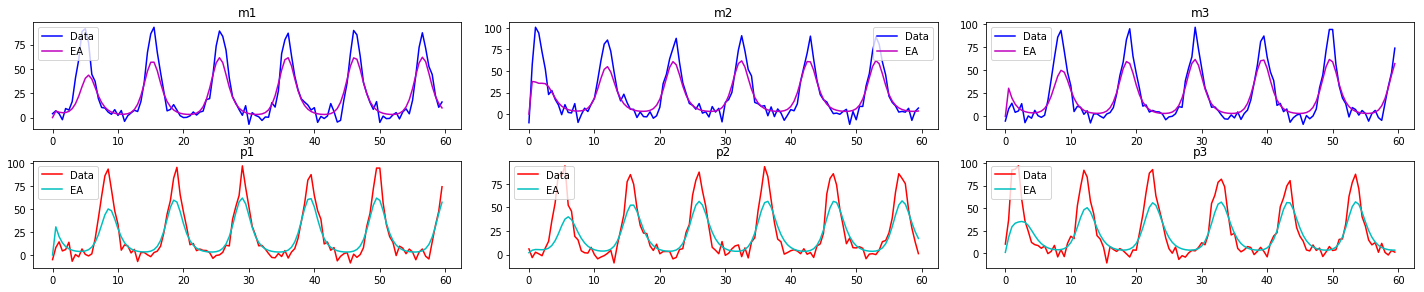

In [105]:
# PLEASE DO NOT REMOVE
# Generate signals for the best performing parameter values
repressilator.set_params(
    x[f.argmin()],
)
t, y_best = repressilator.solve_repressilator()

# Create plots
fig_ea, axs = plt.subplots(2, 3, figsize=(20, 4))
fig_ea.tight_layout()

for i in range(2):
    for j in range(3):
        if i == 0:
            title = "m"
            color = "b"
            color_m = "m"
        else:
            title = "p"
            color = "r"
            color_m = "c"

        axs[i, j].plot(t, y_real[2 * i + j], color, label="Data")
        axs[i, j].plot(t, y_best[2 * i + j], color_m, label="EA")
        axs[i, j].set_title(title + str(j + 1))
        axs[i, j].legend()

Text(0.5, 1.0, '$n$ vs. $\\beta$')

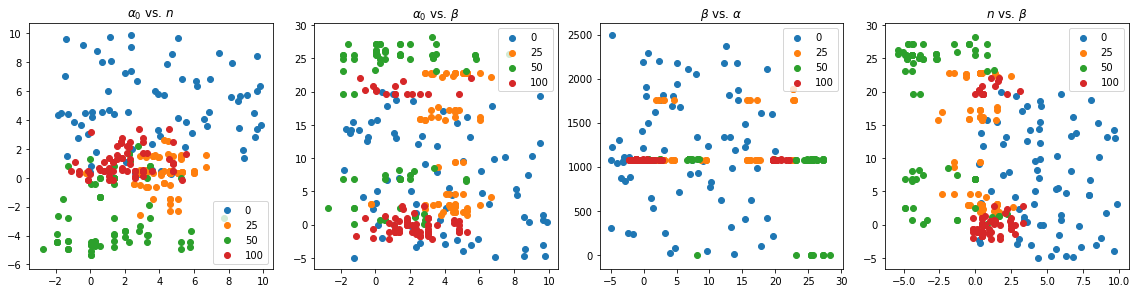

In [106]:
# PLEASE DO NOT REMOVE
# Generate scatterplots for the populations
gens = [0, num_generations // 4, num_generations // 2, num_generations]
fig_ea_pops, axs = plt.subplots(1, 4, figsize=(16, 4))
fig_ea_pops.tight_layout()


for i in range(len(gens)):
    pop_i = populations[gens[i]]
    axs[0].scatter(pop_i[:, 0], pop_i[:, 1], label=str(gens[i]))
    axs[1].scatter(pop_i[:, 0], pop_i[:, 2], label=str(gens[i]))
    axs[2].scatter(pop_i[:, 2], pop_i[:, 3], label=str(gens[i]))
    axs[3].scatter(pop_i[:, 1], pop_i[:, 2], label=str(gens[i]))
axs[0].legend(), axs[1].legend(), axs[2].legend(), axs[3].legend()
axs[0].set_title(r"$\alpha_0$ vs. $n$")
axs[1].set_title(r"$\alpha_0$ vs. $\beta$")
axs[2].set_title(r"$\beta$ vs. $\alpha$")
axs[3].set_title(r"$n$ vs. $\beta$")

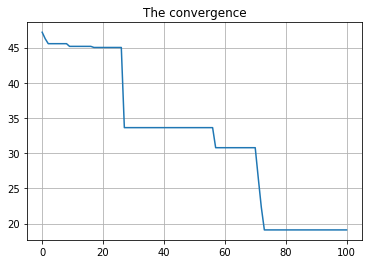

In [107]:
# PLEASE DO NOT REMOVE
# The convergence plot: the best value of the fitness function for each generation
plt.plot(range(len(f_best)), f_best)
plt.title("The convergence")
plt.grid()

## 4. Final remarks: Analysis

Eventually, please answer the following last questions that will allow you to conclude the assignment.

**Question 6 (0-0.5pt)**: After analyzing the results, do you think your algorithm discovered the real values of the parameters? Why? Please indicate which plots indicate that? If not, what is a potential explanation?

**Answer**: From the initial setup of problem we know that alpha_0 is in [−2,10] , n is in [0,10] , beta is in [−5,20] ,and  alpha is in  [500,2500]. From the scatter plots we can observe that while some parameters of our model is in the range while in some of them it is a bit off. We can clearly observe that in earlier generations the parameter values are in a wider range and it gets more collected in later generations. The alpha_0 is in range, n has some negative values but it is very close to 0, beta is out of range that it gets close to 25 and alpha is in the range as well. Also using the wave shapes we can say that we are close to 'recreating' the original wave however we are missing some of the details and sometimes over/under estimating the value.

**Question 7 (0-0.5pt)**: How the population influences the performance of evolutionary algorithms? What population sizes did you use?

**Answer**: During my experiments, I realized that the higher the population size the better the results are. However, it does not neccesarily goes better proportional to increase in size. Like after few generations increasing size from 50 to 75 made more difference than 150 to 200. However, I did not have chance to experiment this in overall generation/steps it was my observation in the very first generations.

I used 75 as my population size as it was the highest feasible population size that I could use. 

**Question 8 (0-0.5pt)**: What are the advantages of your approach?

**Answer**: For my approach, I introduced high variaty of operations and combine different techniques for a operations. I believe it can be a good approach if we do not know the nature of the problem really and we can more easily discover how it works. Also, in this way although model gets more complex, it has a higher chance to be able to adapt the 'right' strategy as we are allowing it to try different things. Also from coding perspective, I tried to cover corner cases and make it more robust. 

**Question 9 (0-0.5pt)**: What are the drawbacks of your approach?

**Answer**: Although I combined many methods and I believe it is also an advantage since it allows us to discover it also introduces randomness a lot. It is hard to reproduce my results over and over thus it is also hard to debug the implementation. I could have also implemented user-given probabilities for changing a specific type of operation., Lastly, this is not directly about the approach but implementation. In order to handle this complexity that this algorithm introduces, I need to somehow either paralelize or using more optimized implementations. Originally, I had many for loops but then replace them with numpy masks. Also there are libraries like cupy that can be used to run the code on GPU. I believe that these would help to speed up the code. But, this might be also about my computer that is not powerful enough to run the code fast enough so that I can tune the hyperparameters better. 

**Question 10 (0-0.5pt)**: How could you improve convergence speed of your algorithm? Please provide very specific answer, ideally supported with literature and mathematical formulas.

**Answer**:
In the survivor selection, we could have use more harsh replacement processes to have a faster convergence. For example, instead of using elitism + ($\mu, \lambda$) selection, we could have used ($\mu + \lambda$) selection & Replace worst (GENITOR) approaches. In this way, in each selection we would have sure that we are only keeping the best for sure. Then it would trivally cause in faster convergence.  However, this has a drawback of getting stuck in local optimum solutions and that is why I did use elitism + ($\mu, \lambda$) selection. (ref: Introduction to Evolutionary Computing, Eiben & Smith) 


**Question 11 (0-0.5pt)**: How does an EA compares with the Metropolis-Hastings algorithm? What are the similarities? What are the differences?

**Answer**: 

*Similarities:*

- Stochasticity: randomness is introduced in both algorithms
- Goal: looking for the best -> 'global optimum'
- Usage: optimization problems in various topics

*Differences:*

- EA uses population and genetic operations to create new generations whereas MH uses MC to find new solutions
- EA can take input type: discrete, cont's, binary, permutation, etc. whereas MH is  for cont's.
- EA is more computationally complex compared to MH. (both the difficulty of implementing many operations and the time complexity of the operations)


